# Spectral encoding of categorical features

About a year ago I was working on a regression model, which had over a million features. Needless to say, the training was super slow, and the model was overfitting a lot. After investigating this issue, I realized that most of the features were created using 1-hot encoding of the categorical features, and some of them had tens of thousands of unique values. 

The problem if mapping categorical features to lower-dimensional space is not new. Recently one of the popular way to deal with it is using entity embedding layers. However that method assumes that neural networks are used. What if we decided to use tree-based algorithms instead? In tis case we can use Spectral Graph Theory methods to create low dimensional embedding of the categorical features.

The idea came from spectral word embedding, spectral clustering and spectral dimensionality reduction algorithms.
If you can define a similarity measure between different values of the categorical features, we can use spectral analysis methods to find the low dimensional representation of the categorical feature. 

From the similarity function (or kernel function) we can construct an Adjacency matrix, which is a symmetric matrix, where the ij element is the value of the kernel function between category values i and j:

$$ A_{ij} = K(i,j) \tag{1}$$

It is very important that I only need a Kernel function, not a high-dimensional representation. This means that 1-hot encoding step is not necessary here. Also for the kernel-base machine learning methods, the categorical variable encoding step is not necessary as well, because what matters is the kernel function between two points, which can be constructed using the individual kernel functions.

Once the adjacency matrix is constructed, we can construct a degree matrix:

$$ D_{ij} = \delta_{ij} \sum_{k}{A_{ik}} \tag{2} $$

Here $\delta$ is the Kronecker delta symbol. The Laplacian matrix is the difference between the two:

$$ L = D - A \tag{3} $$

And the normalize Laplacian matrix is defined as:

$$ \mathscr{L} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}} \tag{4} $$

Following the Spectral Graph theory, we proceed with eigendecomposition of the normalized Laplacian matrix. The number of zero eigenvalues correspond to the number of connected components. In our case, let's assume that our categorical feature has two sets of values that are completely dissimilar. This means that the kernel function $K(i,j)$ is zero if $i$ and $j$ belong to different groups. In this case we will have two zero eigenvalues of the normalized Laplacian matrix.

If there is only one connected component, we will have only one zero eigenvalue. Normally it is uninformative and is dropped to prevent multicollinearity of features. However we can keep it if we are planning to use tree-based models.

The lower eigenvalues correspond to "smooth" eigenvectors, that are following the similarity function more closely. We want to keep only these eigenvectors and drop the eigenvectors with higher eigenvalues, because they are more likely represent noise. It is very common to look for a gap in the matrix spectrum and pick the eigenvalues below the gap. The resulting truncated eigenvectors can be normalized and represent embeddings of the categorical feature values. 

As an example, let's consider the Day of Week. 1-hot encoding assumes every day is similar to any other day ($K(i,j) = 1$). This is not a likely assumption, because we know that days of the week are different. For example, the bar attendance spikes on Fridays and Saturdays (at least in USA) because the following day is a weekend. Label encoding is also incorrect, because it will make the "distance" between Monday and Wednesday twice higher than between Monday and Tuesday. And the "distance" between Sunday and Monday will be six times higher, even though the days are next to each other. By the way, the label encoding corresponds to the kernel $K(i, j) = exp(-\gamma |i-j|)$


In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=130)

In [2]:
def normalized_laplacian(A):
    'Compute normalized Laplacian matrix given the adjacency matrix'
    d = A.sum(axis=0)
    D = np.diag(d)
    L = D-A
    D_rev_sqrt = np.diag(1/np.sqrt(d))
    return D_rev_sqrt @ L @ D_rev_sqrt

We will consider an example, where weekdays are similar to each other, but differ a lot from the weekends. 

In [3]:
#The adjacency matrix for days of the week
A_dw = np.array([[0,10,9,8,5,2,1],
                [0,0,10,9,5,2,1],
                [0,0,0,10,8,2,1],
                [0,0,0,0,10,2,1],
                [0,0,0,0,0,5,3],
                [0,0,0,0,0,0,10],
                [0,0,0,0,0,0,0]])
A_dw = A_dw + A_dw.T
A_dw

array([[ 0, 10,  9,  8,  5,  2,  1],
       [10,  0, 10,  9,  5,  2,  1],
       [ 9, 10,  0, 10,  8,  2,  1],
       [ 8,  9, 10,  0, 10,  2,  1],
       [ 5,  5,  8, 10,  0,  5,  3],
       [ 2,  2,  2,  2,  5,  0, 10],
       [ 1,  1,  1,  1,  3, 10,  0]])

In [4]:
#The normalized Laplacian matrix for days of the week
L_dw_noem = normalized_laplacian(A_dw)
L_dw_noem

array([[ 1.        , -0.27788501, -0.24053512, -0.21380899, -0.14085904, -0.07049074, -0.040996  ],
       [-0.27788501,  1.        , -0.25993762, -0.23394386, -0.13699916, -0.06855912, -0.03987261],
       [-0.24053512, -0.25993762,  1.        , -0.25      , -0.21081851, -0.06593805, -0.03834825],
       [-0.21380899, -0.23394386, -0.25      ,  1.        , -0.26352314, -0.06593805, -0.03834825],
       [-0.14085904, -0.13699916, -0.21081851, -0.26352314,  1.        , -0.17376201, -0.12126781],
       [-0.07049074, -0.06855912, -0.06593805, -0.06593805, -0.17376201,  1.        , -0.50572174],
       [-0.040996  , -0.03987261, -0.03834825, -0.03834825, -0.12126781, -0.50572174,  1.        ]])

In [5]:
#The eigendecomposition of the normalized Laplacian matrix
sz, sv = np.linalg.eig(L_dw_noem)
sz

array([0.        , 0.56794799, 1.50908645, 1.08959831, 1.3053149 , 1.25586378, 1.27218858])

Notice, that the eigenvalues are not ordered here. Let's plot the eigenvalues, ignoring the uninformative zero.

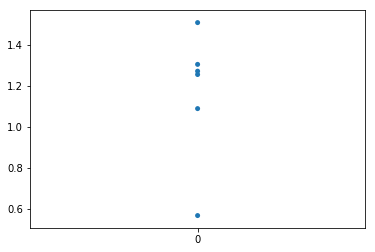

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.stripplot(data=sz[1:], jitter=False, );


We can see a pretty substantial gap between the first eigenvalue and the rest of the eigenvalues. If this does not give enough model performance, you can include the second eigenvalue, because the gap between it and the higher eigenvalues  is also quite substantial. 

Let's print all eigenvectors:

In [7]:
sv

array([[ 0.39180195,  0.22866879,  0.01917247, -0.45504284,  0.12372711, -0.41844908, -0.62957304],
       [ 0.40284079,  0.24416078,  0.01947223, -0.4281388 , -0.53910465, -0.01139734,  0.55105271],
       [ 0.41885391,  0.23795901, -0.0032909 , -0.00102155,  0.24759021,  0.82656956, -0.15299308],
       [ 0.41885391,  0.21778112, -0.01536901,  0.36430356,  0.56996731, -0.36551902,  0.43094387],
       [ 0.39735971, -0.02474713,  0.07869969,  0.66992782, -0.54148697, -0.08518483, -0.29331097],
       [ 0.3176117 , -0.61238751, -0.71702346, -0.09280736,  0.02933834,  0.00752668,  0.02123917],
       [ 0.27305934, -0.63907128,  0.69187421, -0.13963728,  0.11758088,  0.02521838,  0.06615712]])

Look at the second eigenvector. The weekend values have a different size than the weekdays and Friday is close to zero. This proves the transitional role of Friday, that, being a day of the week, is also the beginning of the weekend.

If we are going to pick two lowest non-zero eigenvalues, our categorical feature encoding will result in these category vectors:

In [8]:
#Picking only two eigenvectors
category_vectors = sv[:,[1,3]]
category_vectors

array([[ 0.22866879, -0.45504284],
       [ 0.24416078, -0.4281388 ],
       [ 0.23795901, -0.00102155],
       [ 0.21778112,  0.36430356],
       [-0.02474713,  0.66992782],
       [-0.61238751, -0.09280736],
       [-0.63907128, -0.13963728]])

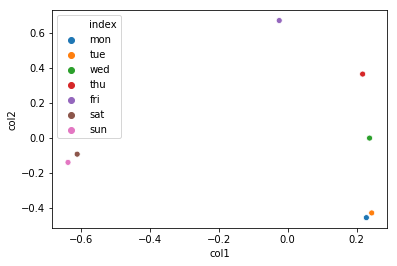

In [9]:
category_vector_frame=pd.DataFrame(category_vectors, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'], 
                                   columns=['col1', 'col2']).reset_index()
sns.scatterplot(data=category_vector_frame, x='col1', y='col2', hue='index');

In the plot above we see that Monday and Tuesday, and also Saturday and Sunday are clustered close together, while Wednesday, Thursday and Friday are far apart. 

## Learning the kernel function
In the previous example we assumed that the similarity function is given. Sometimes this is the case, where it can be defined based on the business rules. However it may be possible to learn it from data.

One of the ways to compute the Kernel is using Kullback-Leibler Divergence:

$$ K(i, j) = \exp(-\gamma \mathscr{D}(i, j)) \tag{5}$$

Where $\mathscr{D}$ is Symmetrised KL divergence:

$$\mathscr{D} = D_{KL}(p_i \parallel p_j) + D_{KL}(p_j \parallel p_i)  \tag{6}$$

Here $p_i$ is a probability of the data given the category value i: 

$$ p_i \equiv P(data | i) $$

The idea is to estimate the data distribution (including the target variable, but excluding the categorical variable) for each value of the categorical variable. If for two values the distributions are similar, then the divergence will be small and the similarity value will be large. Note that $\gamma$ is a hyperparameter and will have to be tuned


To try this approach will will use [liquor sales data set](https://www.kaggle.com/residentmario/iowa-liquor-sales/downloads/iowa-liquor-sales.zip/1). To keep the file small I removed some columns and aggregated the data.


In [10]:
liq = pd.read_csv('Iowa_Liquor_agg.csv', dtype={'Date': 'str', 'Store Number': 'str', 'Category': 'str', 'orders': 'int', 'sales': 'float'},
                 parse_dates=True)
liq.Date = pd.to_datetime(liq.Date)
liq.head()

,Date,Store Number,Category,orders,sales
0,2013-01-02,2200,1011100,1,33.06
1,2013-01-02,2200,1011200,4,79.94
2,2013-01-02,2200,1011300,4,205.32
3,2013-01-02,2200,1011400,1,37.61
4,2013-01-02,2200,1012100,4,399.62


Since we care about sales, let's encode the day of week using the information from the sales column
Let's check the histogram first:

C:\Users\michael.larionov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


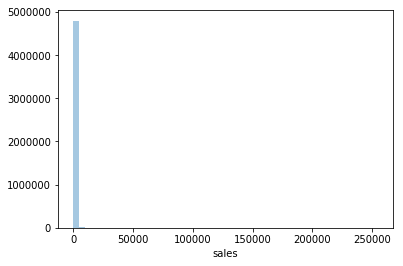

In [11]:
sns.distplot(liq.sales, kde=False);

We see that the distribution is very skewed, so let's try to use log of sales columns instead

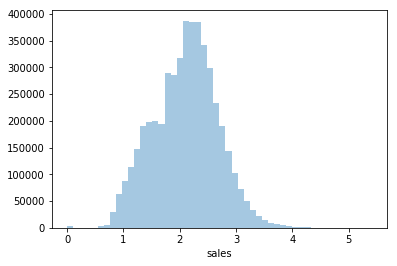

In [12]:
sns.distplot(np.log10(1+liq.sales), kde=False);

This is much better. So we will use a log for our distribution

In [13]:
liq["log_sales"] = np.log10(1+liq.sales)

Here we will follow [this blog](https://amethix.com/entropy-in-machine-learning/) for computation of the Kullback-Leibler divergence.
Also note, that since there are no liquor sales on Sunday, we consider only six days in a week

In [14]:
from scipy.stats import entropy
from numpy import histogram
from scipy.stats import iqr
def kl(x,y):
    # Compute Kullback-Leibler (KL) divergence
    bins_x = max(2,int(2*iqr(x)*len(x)**-(1/3))) # use Freedman-Diaconis's Rule of thumb
    bins_y = max(2,int(2*iqr(y)*len(y)**-(1/3))) 
    bins = np.min([bins_x,bins_y]) # entropy function requires vectors of same length
    prob_x = histogram(x,bins)[0] + np.finfo(float).eps #avoid division by zero error
    prob_y = histogram(y,bins)[0] + np.finfo(float).eps
    kl_dist = entropy(prob_x, prob_y)
    return kl_dist

def symm_kl(x,y):
    return kl(x,y) + kl(y,x)

def dw_data(i):
    return liq[liq.Date.dt.dayofweek == i].log_sales

def kl_from_data(i, j):
    return symm_kl(dw_data(i), dw_data(j))

kl_matrix = np.fromfunction(np.vectorize(kl_from_data), (6,6))

kl_matrix

array([[0.00000000e+00, 8.77075038e-02, 4.67563784e-02, 4.73455185e-02, 4.36580887e-02, 1.10008520e-01],
       [8.77075038e-02, 0.00000000e+00, 6.33458241e-03, 6.12091647e-03, 7.54387432e-03, 1.24807509e-03],
       [4.67563784e-02, 6.33458241e-03, 0.00000000e+00, 1.83170834e-06, 5.27510292e-05, 1.32091396e-02],
       [4.73455185e-02, 6.12091647e-03, 1.83170834e-06, 0.00000000e+00, 7.42423681e-05, 1.28996949e-02],
       [4.36580887e-02, 7.54387432e-03, 5.27510292e-05, 7.42423681e-05, 0.00000000e+00, 1.49325072e-02],
       [1.10008520e-01, 1.24807509e-03, 1.32091396e-02, 1.28996949e-02, 1.49325072e-02, 0.00000000e+00]])

As we already mentioned, the hyperparameter $\gamma$ has to be tuned. Here we just pick the value that will give a plausible result

In [15]:
gamma = 20
kernel = np.exp(-gamma * kl_matrix)
np.fill_diagonal(kernel, 0)
kernel

array([[0.        , 0.17305426, 0.39253579, 0.38793776, 0.41762901, 0.11078428],
       [0.17305426, 0.        , 0.88100529, 0.88477816, 0.85995305, 0.97534746],
       [0.39253579, 0.88100529, 0.        , 0.99996337, 0.99894554, 0.76783317],
       [0.38793776, 0.88477816, 0.99996337, 0.        , 0.99851625, 0.77259995],
       [0.41762901, 0.85995305, 0.99894554, 0.99851625, 0.        , 0.74181889],
       [0.11078428, 0.97534746, 0.76783317, 0.77259995, 0.74181889, 0.        ]])

In [16]:
norm_lap = normalized_laplacian(kernel)

In [17]:
sz, sv = np.linalg.eig(norm_lap)
sz

array([1.11022302e-16, 9.99583797e-01, 1.22897829e+00, 1.27538999e+00, 1.24864532e+00, 1.24740260e+00])

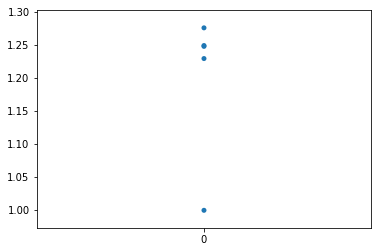

In [18]:
sns.stripplot(data=sz[1:], jitter=False, );

Ignoring the zero eigenvalue, we can see that there is a biger gap between the first eigenvalue and the rest of the eigenvalues, even though the values are all in the range between 1 and 1.3. Looking at the igenvectors,

In [19]:
sv

array([[ 2.67401577e-01,  7.84572270e-01,  5.54718343e-01,  2.76258671e-04, -7.14070476e-02, -1.14572007e-02],
       [ 4.26734144e-01, -3.72668177e-01,  3.22609973e-01,  7.58146923e-01,  1.20542354e-02,  2.67276880e-03],
       [ 4.41524080e-01,  8.75061081e-02, -3.74919359e-01, -4.19119099e-02, -4.09814486e-01,  6.97947076e-01],
       [ 4.41715953e-01,  7.76798872e-02, -3.85187524e-01, -3.81301800e-02, -3.70005207e-01, -7.15629555e-01],
       [ 4.40242523e-01,  1.40697188e-01, -3.03782012e-01, -6.26600204e-02,  8.30409808e-01,  2.45068326e-02],
       [ 4.03143140e-01, -4.60518839e-01,  4.54964725e-01, -6.46588253e-01, -1.79865129e-02, -2.28526205e-03]])

Ultimately the number of eigenvectors to use is another hyperparameter, that should be optimized on a supervised learning task. The Category field is another candidate to do spectral analysis, and is, probably, a better choice since it has more unique values

In [20]:
len(liq.Category.unique())

107

In [21]:
unique_categories = liq.Category.unique()
def dw_data_c(i):
    return liq[liq.Category == unique_categories[int(i)]].log_sales

def kl_from_data_c(i, j):
    return symm_kl(dw_data_c(i), dw_data_c(j))

#WARNING: THIS WILL TAKE A LONG TIME
kl_matrix = np.fromfunction(np.vectorize(kl_from_data_c), (107,107))
kl_matrix

array([[0.00000000e+00, 1.01321384e-02, 2.38664557e-01, ..., 5.83930416e-02, 2.05621708e+01, 4.44786939e-01],
       [1.01321384e-02, 0.00000000e+00, 1.50225839e-01, ..., 1.17178087e-01, 2.24843754e+01, 5.89215704e-01],
       [2.38664557e-01, 1.50225839e-01, 0.00000000e+00, ..., 5.33952956e-01, 2.95549456e+01, 1.33572924e+00],
       ...,
       [5.83930416e-02, 1.17178087e-01, 5.33952956e-01, ..., 0.00000000e+00, 1.59700549e+01, 1.80637715e-01],
       [2.05621708e+01, 2.24843754e+01, 2.95549456e+01, ..., 1.59700549e+01, 0.00000000e+00, 8.58405693e+00],
       [4.44786939e-01, 5.89215704e-01, 1.33572924e+00, ..., 1.80637715e-01, 8.58405693e+00, 0.00000000e+00]])

In [42]:
def plot_eigenvalues(gamma):
    "Eigendecomposition of the kernel and plot of the eigenvalues"
    kernel = np.exp(-gamma * kl_matrix)
    np.fill_diagonal(kernel, 0)
    norm_lap = normalized_laplacian(kernel)
    sz, sv = np.linalg.eig(norm_lap)
    sns.stripplot(data=sz[1:], jitter=True, );

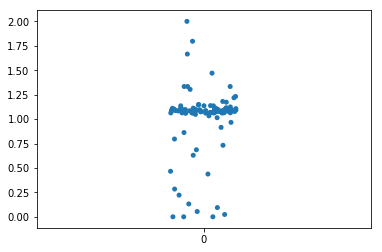

In [43]:
plot_eigenvalues(100);

We can see, that a lot of eigenvalues are grouped around the 1.1 mark. The eigenvalues that are below that cluster can be used for encoding the Category feature.
Please also note that this method is highly sensitive on selection of hyperparameter $\gamma$. For illustration let me pick a higher and a lower gamma

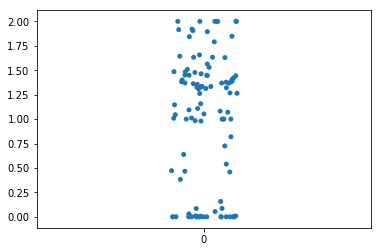

In [45]:
plot_eigenvalues(7000);

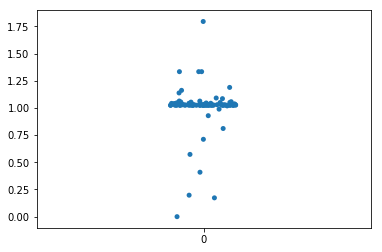

In [46]:
plot_eigenvalues(10)

## Conclusion and next steps

We presented a way to encode the categorical features as a low dimensional vector that preserves most of the feature similarity information. For this we use methods of Spectral analysis on the values of the categorical feature. In order to find the kernel function we can either use heuristics, or learn it using a variety of methods, for example, using Kullback–Leibler divergence of the data distribution conditional on the category value. To select the subset of the eigenvectors we used gap analysis, but what we really need is to validate this methods by analyzing a variety of datasets and both classification and regression problems. We also need to compare it with other encoding methods, for example, entity embedding using Neural Networks. The kernel function we used can also include the information about category frequency, which will help us deal with high information, but low frequency values.

